In [ ]:
!pip install -q torch torchvision transformers tqdm scikit-learn pillow numpy git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import argparse

# --- 1. The Smart Unified Dataset ---
class UnifiedClipDataset(Dataset):
    def __init__(self, json_path, image_root, processor, mode='train'):
        """
        mode: 'train' (shuffles options) or 'test' (fixed order)
        """
        with open(json_path, 'r') as f:
            raw_data = json.load(f)

        self.image_root = image_root
        self.processor = processor
        self.mode = mode
        self.data = []

        # --- 1. SMART PRE-PROCESSING (The Fix) ---
        # We transform the data in memory to match the required format
        for item in raw_data:

            # CASE A: Old Attribute Format (The one causing errors)
            # It has 'base_image' and 'swap_image' in one entry
            if 'base_caption' in item and 'swap_caption' in item:
                # Create Entry 1: The Base Image
                # Correct Answer: base_caption (index 0)
                self.data.append({
                    'file_name': item['base_image'], # Use base image
                    'options': [item['base_caption'], item['swap_caption']],
                    'correct_index': 0
                })

                # Create Entry 2: The Swapped Image
                # Correct Answer: swap_caption (index 1)
                self.data.append({
                    'file_name': item['swap_image'], # Use swap image
                    'options': [item['base_caption'], item['swap_caption']],
                    'correct_index': 1
                })

            # CASE B: Negation Format
            elif 'negated_caption' in item:
                self.data.append({
                    'file_name': item.get('file_name', item.get('image')),
                    'options': [item['correct_caption'], item['negated_caption']],
                    'correct_index': 0
                })

            # CASE C: Numeracy Format
            elif 'foils' in item:
                self.data.append({
                    'file_name': item.get('file_name', item.get('image')),
                    'options': [item['correct_caption']] + item['foils'],
                    'correct_index': 0
                })

            # CASE D: Already Correct (Spatial or Fixed Attribute)
            elif 'options' in item:
                self.data.append(item)

            else:
                # print(f"Skipping unknown format: {list(item.keys())}")
                pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # --- A. Image Loading ---
        img_name = item.get('file_name', item.get('image', ''))

        # Fix for paths that might be "images/file.png" vs just "file.png"
        if self.image_root in img_name:
            image_path = img_name
        else:
            image_path = os.path.join(self.image_root, img_name)

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # --- B. Get Normalized Data ---
        options = item['options']
        correct_idx = item['correct_index']

        # --- C. Shuffle for Training ---
        if self.mode == 'train':
            labeled_options = [(opt, i == correct_idx) for i, opt in enumerate(options)]
            random.shuffle(labeled_options)
            options = [opt for opt, _ in labeled_options]
            correct_idx = next(i for i, (opt, is_correct) in enumerate(labeled_options) if is_correct)

        # --- D. Tokenization ---
        inputs = self.processor(
            text=options,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "label": torch.tensor(correct_idx, dtype=torch.long)
        }

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    input_ids = torch.stack([x["input_ids"] for x in batch])
    attention_mask = torch.stack([x["attention_mask"] for x in batch])
    labels = torch.stack([x["label"] for x in batch])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# --- 2. Linear Probe Setup ---
def train_linear_probe(args):
    # Config
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load CLIP
    print(f"Loading {args.model_id}...")
    model = CLIPModel.from_pretrained(args.model_id)
    processor = CLIPProcessor.from_pretrained(args.model_id)

    # --- THE LINEAR PROBE TRICK ---
    # 1. Freeze EVERYTHING first
    for param in model.parameters():
        param.requires_grad = False

    # 2. Unfreeze ONLY the visual projection layer
    # This allows the image embeddings to "rotate" to match the text better
    # without destroying the pre-trained knowledge.
    model.visual_projection.requires_grad_(True)

    print("Model configured for Linear Probe: Visual Projection Unfrozen.")
    print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    model.to(device)

    # Data Loaders
    dataset = UnifiedClipDataset(args.train_json, args.image_root, processor, mode='train')

    # Simple split (you can make this more robust if you have separate val files)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, collate_fn=collate_fn)

    # Optimizer & Loss
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    # Training Loop
    best_val_acc = 0
    save_path = os.path.join(args.output_dir, "linear_probe_best.pt")

    for epoch in range(args.epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs}")
        for batch in pbar:
            optimizer.zero_grad()

            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward Pass
            # Get Image Features
            img_embeds = model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            # Get Text Features (Batch x Options x Dim)
            B, K, SeqLen = input_ids.shape
            flat_input_ids = input_ids.view(-1, SeqLen)
            flat_attention_mask = attention_mask.view(-1, SeqLen)

            text_embeds = model.get_text_features(flat_input_ids, flat_attention_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            # Compute Logits (Dot Product)
            # [B, Dim] * [B, K, Dim] -> [B, K]
            logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)

            # Scale by temperature (logit_scale)
            logit_scale = model.logit_scale.exp()
            logits = logits * logit_scale

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += B

            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': train_correct/train_total})

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                img_embeds = model.get_image_features(pixel_values)
                img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

                B, K, SeqLen = input_ids.shape
                flat_input_ids = input_ids.view(-1, SeqLen)
                flat_attention_mask = attention_mask.view(-1, SeqLen)

                text_embeds = model.get_text_features(flat_input_ids, flat_attention_mask)
                text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
                text_embeds = text_embeds.view(B, K, -1)

                logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += B

        val_acc = val_correct / val_total
        print(f"Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model to {save_path}")

# --- 3. Entry Point ---
if __name__ == "__main__":
    # You can run this block directly in Colab
    # Or simulate args if running interactively
    class Args:
        train_json = "/content/data/testBed/negation_train_5000/negation_metadata.json" # CHANGE THIS per task
        image_root = "/content/data/testBed/negation_train_5000" # CHANGE THIS per task
        output_dir = "runs/negation_linear_probe"
        model_id = "openai/clip-vit-base-patch32"
        batch_size = 32
        lr = 1e-4
        epochs = 5

    args = Args()
    os.makedirs(args.output_dir, exist_ok=True)

    # Run Training
    # Uncomment the line below to run!
    # train_linear_probe(args)

In [ ]:
import os

# Define where to save models in Google Drive
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Define where your data was unzipped
DATA_ROOT = "/content/gdrive/MyDrive/team_biased/trainBed"

# Quick check to list folders so we don't crash on typos
print("Checking data folders...")
if os.path.exists(DATA_ROOT):
    print(f"Found: {os.listdir(DATA_ROOT)}")
else:
    print(f"❌ ERROR: {DATA_ROOT} not found. Did you unzip the dataset?")

Checking data folders...
Found: ['.DS_Store', 'numeracy_1250', 'attribute_1250', 'negation_1250', 'spatial_1250']


In [ ]:
class NegationArgs:
    train_json = f"{DATA_ROOT}/negation_1250/negation_metadata.json"
    image_root = f"{DATA_ROOT}/negation_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "negation")

    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4  # Linear probe specific LR
    epochs = 6

# Create output folder
os.makedirs(NegationArgs.output_dir, exist_ok=True)

print(f"\n========================================")
print(f"🚀 STARTING NEGATION LINEAR PROBE")
print(f"========================================\n")

# Run Training
train_linear_probe(NegationArgs())


🚀 STARTING NEGATION LINEAR PROBE

Using device: cuda
Loading openai/clip-vit-base-patch32...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Model configured for Linear Probe: Visual Projection Unfrozen.
Trainable params: 393216


Epoch 1/6: 100%|██████████| 36/36 [09:49<00:00, 16.36s/it, loss=0.523, acc=0.75]


Val Accuracy: 0.8346
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/negation/linear_probe_best.pt


Epoch 2/6: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s, loss=0.306, acc=0.904]


Val Accuracy: 0.8740
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/negation/linear_probe_best.pt


Epoch 3/6: 100%|██████████| 36/36 [00:20<00:00,  1.74it/s, loss=0.221, acc=0.956]


Val Accuracy: 0.9055
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/negation/linear_probe_best.pt


Epoch 4/6: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s, loss=0.166, acc=0.976]


Val Accuracy: 0.9055


Epoch 5/6: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s, loss=0.129, acc=0.986]


Val Accuracy: 0.9055


Epoch 6/6: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s, loss=0.102, acc=0.992]


Val Accuracy: 0.8898


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import CLIPModel, CLIPProcessor

def evaluate_and_plot(task_name, test_json_path, test_image_root, model_path):
    print(f"\n📊 DEEP EVALUATION: {task_name.upper()}...")

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Load Model & Data
    # Load base to get architecture, then load trained weights
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    # CRITICAL: If evaluating Linear Probe, unfreeze projection so keys match
    # If evaluating LoRA, we might need a slightly different load strategy,
    # but for Linear Probe .pt files, this works:
    model.visual_projection.requires_grad_(True)

    print(f"Loading weights from: {model_path}")
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict, strict=False) # strict=False allows loading partial weights if needed
    model.to(device)
    model.eval()

    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # mode='test' ensures fixed order (Correct is always index 0)
    test_dataset = UnifiedClipDataset(test_json_path, test_image_root, processor, mode='test')
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    # 2. Metrics Storage
    all_deltas = []
    all_is_correct = []
    all_correct_probs = []

    print("Running Inference...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # --- Forward Pass ---
            # Image Features
            img_embeds = model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            # Text Features
            B, K, SeqLen = input_ids.shape
            flat_input = input_ids.view(-1, SeqLen)
            flat_mask = attention_mask.view(-1, SeqLen)

            text_embeds = model.get_text_features(flat_input, flat_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            # --- Calculate RAW Cosine Similarity (No Temperature) ---
            # This gives us the raw "distance" in embedding space
            # Shape: [Batch, K_options]
            raw_scores = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)

            # --- Calculate Probabilities (With Temperature) ---
            logit_scale = model.logit_scale.exp()
            logits = raw_scores * logit_scale
            probs = torch.softmax(logits, dim=1)

            # --- Compute Metrics per Sample ---
            for i in range(B):
                correct_idx = labels[i].item()

                # 1. Get score of the correct answer
                score_correct = raw_scores[i, correct_idx].item()
                prob_correct = probs[i, correct_idx].item()

                # 2. Get score of the BEST incorrect answer
                # Mask out the correct index to find max of the rest
                mask = torch.ones(K, dtype=torch.bool)
                mask[correct_idx] = False
                score_top_incorrect = raw_scores[i][mask].max().item()

                # 3. Calculate Delta (Margin)
                delta = score_correct - score_top_incorrect

                # 4. Did it get it right? (Argmax)
                pred_idx = logits[i].argmax().item()
                is_correct = (pred_idx == correct_idx)

                all_deltas.append(delta)
                all_is_correct.append(is_correct)
                all_correct_probs.append(prob_correct)

    # 3. Analyze Results
    all_deltas = np.array(all_deltas)
    accuracy = np.mean(all_is_correct) * 100
    mean_delta = np.mean(all_deltas)

    pct_tiny_margin = (all_deltas <= 0.01).mean() * 100
    pct_confident = (all_deltas > 0.05).mean() * 100

    print("\n" + "="*40)
    print(f"RESULTS FOR: {task_name.upper()}")
    print("="*40)
    print(f"Samples evaluated:    {len(all_deltas)}")
    print(f"Accuracy:             {accuracy:.2f}%")
    print(f"Mean Delta (Cosine):  {mean_delta:.5f}")
    print(f"% Delta <= 0.01 (Weak): {pct_tiny_margin:.2f}%")
    print(f"% Delta > 0.05 (Strong): {pct_confident:.2f}%")
    print(f"Mean Prob (Correct):  {np.mean(all_correct_probs):.4f}")

    # 4. Plot Histogram (Just like your screenshot!)
    plt.figure(figsize=(8, 5))
    plt.hist(all_deltas, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=1, label="Decision Boundary")
    plt.title(f"Histogram of Similarity Delta ({task_name})")
    plt.xlabel("Delta (Correct - Top Incorrect Cosine Sim)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Example Usage ---
# evaluate_and_plot(
#    "negation",
#    "/content/data/testBed/negation_test_400/negation_metadata.json",
#    "/content/data/testBed/negation_test_400",
#    "/content/drive/MyDrive/clip_linear_probe_experiments/negation/linear_probe_best.pt"
# )


📊 DEEP EVALUATION: NEGATION...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/negation/linear_probe_best.pt
Running Inference...


100%|██████████| 7/7 [01:47<00:00, 15.29s/it]



RESULTS FOR: NEGATION
Samples evaluated:    200
Accuracy:             84.00%
Mean Delta (Cosine):  0.01604
% Delta <= 0.01 (Weak): 33.00%
% Delta > 0.05 (Strong): 0.50%
Mean Prob (Correct):  0.7620


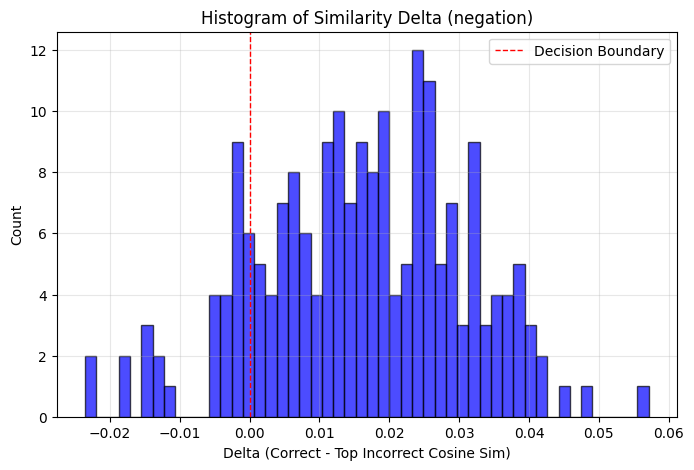

In [ ]:
evaluate_and_plot(
   "negation",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200/negation_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200",
   "/content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/negation/linear_probe_best.pt"
)

In [ ]:
class NumeracyArgs:
    # Adjust folder name if yours is different
    train_json = f"{DATA_ROOT}/numeracy_1250/numeracy_metadata_fixed.json"
    image_root = f"{DATA_ROOT}/numeracy_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "numeracy")

    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 6

os.makedirs(NumeracyArgs.output_dir, exist_ok=True)

print(f"\n========================================")
print(f"🚀 STARTING NUMERACY LINEAR PROBE")
print(f"========================================\n")

train_linear_probe(NumeracyArgs())


🚀 STARTING NUMERACY LINEAR PROBE

Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Linear Probe: Visual Projection Unfrozen.
Trainable params: 393216


Epoch 1/6: 100%|██████████| 36/36 [09:43<00:00, 16.20s/it, loss=0.987, acc=0.432]


Val Accuracy: 0.5200
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/numeracy/linear_probe_best.pt


Epoch 2/6: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.839, acc=0.637]


Val Accuracy: 0.5040


Epoch 3/6: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, loss=0.772, acc=0.697]


Val Accuracy: 0.5280
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/numeracy/linear_probe_best.pt


Epoch 4/6: 100%|██████████| 36/36 [00:27<00:00,  1.29it/s, loss=0.711, acc=0.732]


Val Accuracy: 0.5360
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/numeracy/linear_probe_best.pt


Epoch 5/6: 100%|██████████| 36/36 [00:28<00:00,  1.28it/s, loss=0.655, acc=0.767]


Val Accuracy: 0.4960


Epoch 6/6: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, loss=0.615, acc=0.775]


Val Accuracy: 0.4880



📊 DEEP EVALUATION: NUMERACY...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/numeracy/linear_probe_best.pt
Running Inference...


100%|██████████| 5/5 [01:15<00:00, 15.17s/it]



RESULTS FOR: NUMERACY
Samples evaluated:    150
Accuracy:             56.67%
Mean Delta (Cosine):  0.00249
% Delta <= 0.01 (Weak): 77.33%
% Delta > 0.05 (Strong): 0.00%
Mean Prob (Correct):  0.4679


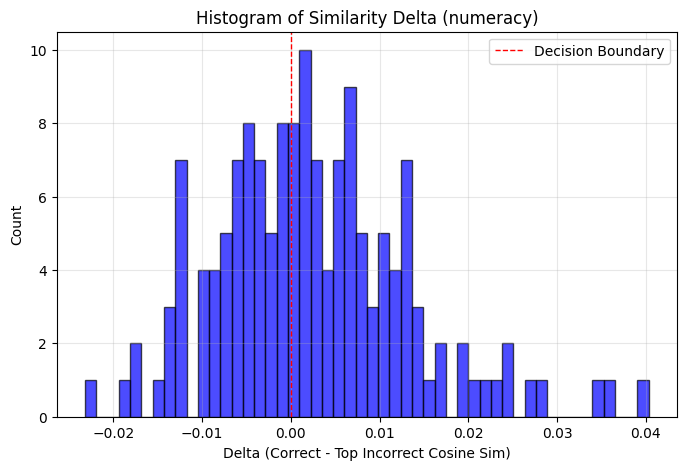

In [ ]:
evaluate_and_plot(
   "numeracy",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150/numeracy_metadata_fixed.json",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150",
   "/content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/numeracy/linear_probe_best.pt"
)

In [ ]:
class AttributeArgs:
    train_json = f"{DATA_ROOT}/attribute_1250/attributes_metadata.json"
    image_root = f"{DATA_ROOT}/attribute_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "attribute")

    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 6

os.makedirs(AttributeArgs.output_dir, exist_ok=True)

print(f"\n========================================")
print(f"🚀 STARTING ATTRIBUTE LINEAR PROBE")
print(f"========================================\n")

train_linear_probe(AttributeArgs())


🚀 STARTING ATTRIBUTE LINEAR PROBE

Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Linear Probe: Visual Projection Unfrozen.
Trainable params: 393216


Epoch 1/6: 100%|██████████| 36/36 [08:00<00:00, 13.34s/it, loss=0.716, acc=0.502]


Val Accuracy: 0.5040
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/attribute/linear_probe_best.pt


Epoch 2/6: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.649, acc=0.587]


Val Accuracy: 0.4080


Epoch 3/6: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s, loss=0.607, acc=0.667]


Val Accuracy: 0.4720


Epoch 4/6: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, loss=0.581, acc=0.698]


Val Accuracy: 0.4880


Epoch 5/6: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s, loss=0.528, acc=0.733]


Val Accuracy: 0.5360
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/attribute/linear_probe_best.pt


Epoch 6/6: 100%|██████████| 36/36 [00:28<00:00,  1.28it/s, loss=0.476, acc=0.765]


Val Accuracy: 0.5040



📊 DEEP EVALUATION: ATTRIBUTE...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/attribute/linear_probe_best.pt
Running Inference...


100%|██████████| 5/5 [01:07<00:00, 13.43s/it]



RESULTS FOR: ATTRIBUTE
Samples evaluated:    150
Accuracy:             68.00%
Mean Delta (Cosine):  0.00443
% Delta <= 0.01 (Weak): 79.33%
% Delta > 0.05 (Strong): 0.00%
Mean Prob (Correct):  0.5847


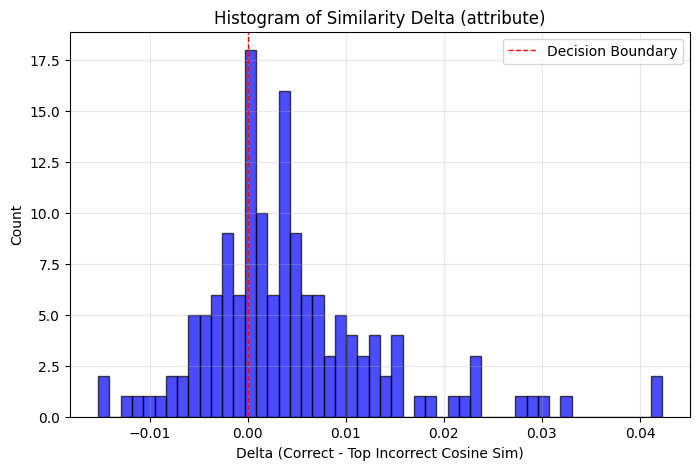

In [ ]:
evaluate_and_plot(
   "attribute",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset/attributes_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset",
   "/content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/attribute/linear_probe_best.pt"
)

In [ ]:
class SpatialArgs:
    train_json = f"{DATA_ROOT}/spatial_1250/spatial_metadata.json"
    image_root = f"{DATA_ROOT}/spatial_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "spatial")

    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 7

os.makedirs(SpatialArgs.output_dir, exist_ok=True)

print(f"\n========================================")
print(f"🚀 STARTING SPATIAL LINEAR PROBE")
print(f"========================================\n")

train_linear_probe(SpatialArgs())


🚀 STARTING SPATIAL LINEAR PROBE

Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Linear Probe: Visual Projection Unfrozen.
Trainable params: 393216


Epoch 1/7: 100%|██████████| 36/36 [12:17<00:00, 20.49s/it, loss=0.765, acc=0.458]


Val Accuracy: 0.4880
Saved new best model to /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/spatial/linear_probe_best.pt


Epoch 2/7: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.723, acc=0.469]


Val Accuracy: 0.4560


Epoch 3/7: 100%|██████████| 36/36 [00:19<00:00,  1.80it/s, loss=0.708, acc=0.533]


Val Accuracy: 0.3200


Epoch 4/7: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s, loss=0.698, acc=0.541]


Val Accuracy: 0.3600


Epoch 5/7: 100%|██████████| 36/36 [00:19<00:00,  1.84it/s, loss=0.686, acc=0.581]


Val Accuracy: 0.3040


Epoch 6/7: 100%|██████████| 36/36 [00:19<00:00,  1.82it/s, loss=0.683, acc=0.583]


Val Accuracy: 0.3360


Epoch 7/7: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s, loss=0.676, acc=0.591]


Val Accuracy: 0.3760



📊 DEEP EVALUATION: SPATIAL...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/spatial/linear_probe_best.pt
Running Inference...


100%|██████████| 5/5 [02:00<00:00, 24.12s/it]



RESULTS FOR: SPATIAL
Samples evaluated:    150
Accuracy:             49.33%
Mean Delta (Cosine):  0.00005
% Delta <= 0.01 (Weak): 94.67%
% Delta > 0.05 (Strong): 0.00%
Mean Prob (Correct):  0.5012


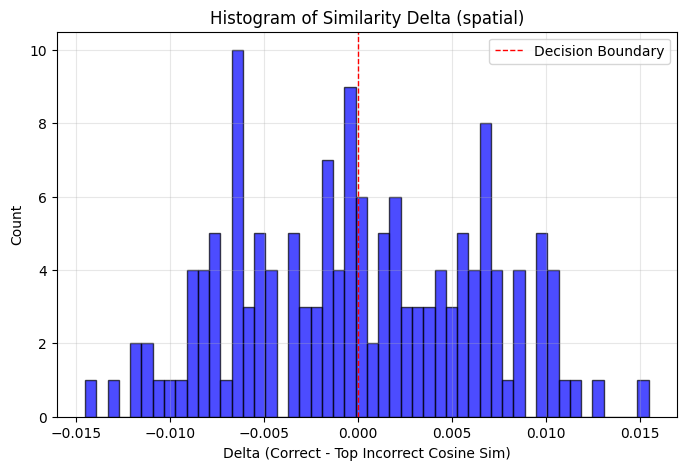

In [ ]:
evaluate_and_plot(
   "spatial",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset/spatial_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset",
   "/content/gdrive/MyDrive/team_biased/clip_linear_probe_experiments/spatial/linear_probe_best.pt"
)

Text Head FT

In [ ]:
def train_text_head(args):
    # Config
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # 1. Load CLIP
    print(f"Loading {args.model_id}...")
    model = CLIPModel.from_pretrained(args.model_id)
    processor = CLIPProcessor.from_pretrained(args.model_id)

    # --- TEXT-HEAD CONFIGURATION ---
    # 1. Freeze EVERYTHING first
    for param in model.parameters():
        param.requires_grad = False

    # 2. Unfreeze ONLY the Text Projection
    # This allows the text embeddings to "rotate" to match the images
    model.text_projection.requires_grad_(True)
    # Optional: Unfreeze final layer norm for stability
    model.text_model.final_layer_norm.requires_grad_(True)

    print("Model configured for Text-Head FT: Text Projection Unfrozen.")
    print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    model.to(device)

    # 2. Data Loaders
    dataset = UnifiedClipDataset(args.train_json, args.image_root, processor, mode='train')

    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, collate_fn=collate_fn)

    # 3. Optimizer & Loss
    # We use a slightly smaller LR for text-head than linear probe usually
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    # 4. Training Loop
    best_val_acc = 0
    save_path = os.path.join(args.output_dir, "text_head_best.pt")

    for epoch in range(args.epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs}")
        for batch in pbar:
            optimizer.zero_grad()

            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward Pass
            img_embeds = model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            B, K, SeqLen = input_ids.shape
            flat_input_ids = input_ids.view(-1, SeqLen)
            flat_attention_mask = attention_mask.view(-1, SeqLen)

            text_embeds = model.get_text_features(flat_input_ids, flat_attention_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
            logit_scale = model.logit_scale.exp()
            logits = logits * logit_scale

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += B

            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': train_correct/train_total})

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                img_embeds = model.get_image_features(pixel_values)
                img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

                B, K, SeqLen = input_ids.shape
                flat_input_ids = input_ids.view(-1, SeqLen)
                flat_attention_mask = attention_mask.view(-1, SeqLen)

                text_embeds = model.get_text_features(flat_input_ids, flat_attention_mask)
                text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
                text_embeds = text_embeds.view(B, K, -1)

                logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += B

        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Epoch {epoch+1}: Val Acc {val_acc:.4f} -> Saved best model")


🚀 STARTING NEGATION TEXT-HEAD TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Text-Head FT: Text Projection Unfrozen.
Trainable params: 263168


Epoch 1/6: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s, loss=0.51, acc=0.755]


Epoch 1: Val Acc 0.7953 -> Saved best model


Epoch 2/6: 100%|██████████| 36/36 [00:26<00:00,  1.34it/s, loss=0.297, acc=0.922]


Epoch 2: Val Acc 0.8189 -> Saved best model


Epoch 3/6: 100%|██████████| 36/36 [00:25<00:00,  1.39it/s, loss=0.193, acc=0.954]


Epoch 3: Val Acc 0.8346 -> Saved best model


Epoch 6/6: 100%|██████████| 36/36 [00:20<00:00,  1.73it/s, loss=0.0473, acc=0.995]


Epoch 6: Val Acc 0.8425 -> Saved best model

📊 EVALUATING NEGATION...

📊 DEEP EVALUATION: NEGATION...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_text_head_experiments/negation/text_head_best.pt
Running Inference...


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]



RESULTS FOR: NEGATION
Samples evaluated:    200
Accuracy:             88.00%
Mean Delta (Cosine):  0.03840
% Delta <= 0.01 (Weak): 20.50%
% Delta > 0.05 (Strong): 38.50%
Mean Prob (Correct):  0.8477


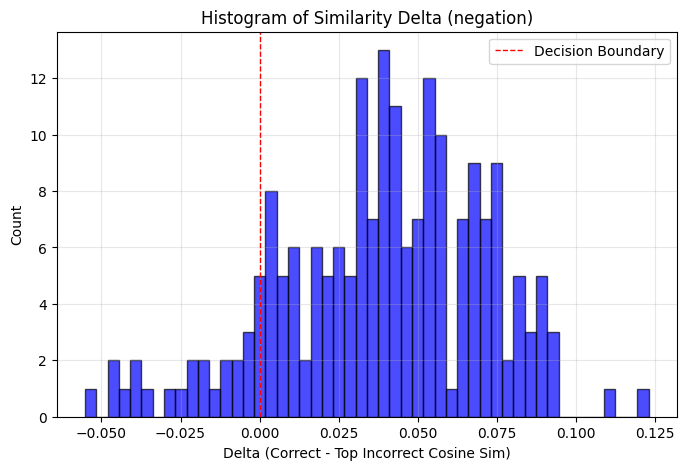

In [ ]:
# Setup Args
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_text_head_experiments"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)
class NegationHeadArgs:
    train_json = f"{DATA_ROOT}/negation_1250/negation_metadata.json"
    image_root = f"{DATA_ROOT}/negation_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "negation")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 6


os.makedirs(NegationHeadArgs.output_dir, exist_ok=True)

# 1. TRAIN
print("\n🚀 STARTING NEGATION TEXT-HEAD TRAINING")
train_text_head(NegationHeadArgs())
# 2. EVALUATE
print("\n📊 EVALUATING NEGATION...")
evaluate_and_plot(
   "negation",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200/negation_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200",
    os.path.join(NegationHeadArgs.output_dir, "text_head_best.pt")
)


🚀 STARTING NUMERACY TEXT-HEAD TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Text-Head FT: Text Projection Unfrozen.
Trainable params: 263168


Epoch 1/12: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s, loss=0.973, acc=0.423]


Epoch 1: Val Acc 0.4800 -> Saved best model


Epoch 3/12: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s, loss=0.755, acc=0.68]


Epoch 3: Val Acc 0.4880 -> Saved best model


Epoch 12/12: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.26, acc=0.928]



📊 EVALUATING NUMERACY...

📊 DEEP EVALUATION: NUMERACY...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_text_head_experiments/numeracy/text_head_best.pt
Running Inference...


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



RESULTS FOR: NUMERACY
Samples evaluated:    150
Accuracy:             61.33%
Mean Delta (Cosine):  0.00291
% Delta <= 0.01 (Weak): 78.00%
% Delta > 0.05 (Strong): 0.00%
Mean Prob (Correct):  0.4797


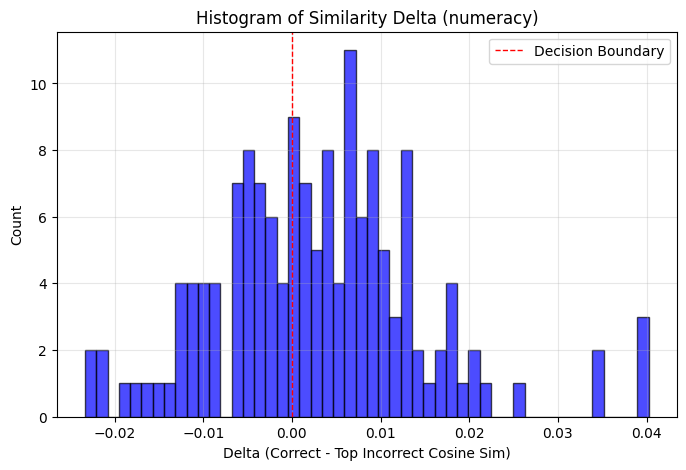

In [ ]:
class NumeracyHeadArgs:
    train_json = f"{DATA_ROOT}/numeracy_1250/numeracy_metadata_fixed.json"
    image_root = f"{DATA_ROOT}/numeracy_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "numeracy")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 12

os.makedirs(NumeracyHeadArgs.output_dir, exist_ok=True)

# 1. TRAIN
print("\n🚀 STARTING NUMERACY TEXT-HEAD TRAINING")
train_text_head(NumeracyHeadArgs())

# 2. EVALUATE
print("\n📊 EVALUATING NUMERACY...")
evaluate_and_plot(
   "numeracy",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150/numeracy_metadata_fixed.json",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150",
    os.path.join(NumeracyHeadArgs.output_dir, "text_head_best.pt")
)


🚀 STARTING ATTRIBUTE TEXT-HEAD TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Text-Head FT: Text Projection Unfrozen.
Trainable params: 263168


Epoch 1/6: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.727, acc=0.506]


Epoch 1: Val Acc 0.4480 -> Saved best model


Epoch 6/6: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, loss=0.539, acc=0.743]



📊 EVALUATING ATTRIBUTE...

📊 DEEP EVALUATION: ATTRIBUTE...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_text_head_experiments/attribute/text_head_best.pt
Running Inference...


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


RESULTS FOR: ATTRIBUTE
Samples evaluated:    150
Accuracy:             56.67%
Mean Delta (Cosine):  0.00093
% Delta <= 0.01 (Weak): 96.67%
% Delta > 0.05 (Strong): 0.00%
Mean Prob (Correct):  0.5202


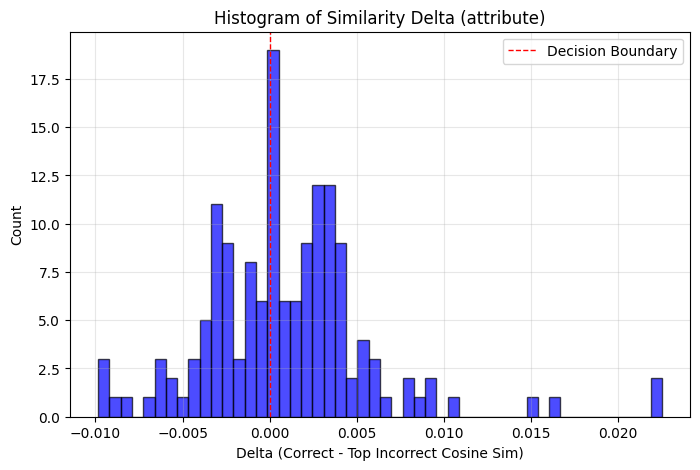

In [ ]:
class AttributeHeadArgs:
    train_json = f"{DATA_ROOT}/attribute_1250/attributes_metadata.json"
    image_root = f"{DATA_ROOT}/attribute_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "attribute")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 6

os.makedirs(AttributeHeadArgs.output_dir, exist_ok=True)

# 1. TRAIN
print("\n🚀 STARTING ATTRIBUTE TEXT-HEAD TRAINING")
train_text_head(AttributeHeadArgs())

# 2. EVALUATE
print("\n📊 EVALUATING ATTRIBUTE...")
evaluate_and_plot(
    "attribute",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset/attributes_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset",
    os.path.join(AttributeHeadArgs.output_dir, "text_head_best.pt")
)


🚀 STARTING SPATIAL TEXT-HEAD TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for Text-Head FT: Text Projection Unfrozen.
Trainable params: 263168


Epoch 1/7: 100%|██████████| 36/36 [00:19<00:00,  1.83it/s, loss=0.764, acc=0.445]


Epoch 1: Val Acc 0.5040 -> Saved best model


Epoch 7/7: 100%|██████████| 36/36 [00:19<00:00,  1.80it/s, loss=0.674, acc=0.586]



📊 EVALUATING SPATIAL...

📊 DEEP EVALUATION: SPATIAL...
Loading weights from: /content/gdrive/MyDrive/team_biased/clip_text_head_experiments/spatial/text_head_best.pt
Running Inference...


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


RESULTS FOR: SPATIAL
Samples evaluated:    150
Accuracy:             50.67%
Mean Delta (Cosine):  0.00003
% Delta <= 0.01 (Weak): 93.33%
% Delta > 0.05 (Strong): 0.00%
Mean Prob (Correct):  0.5005


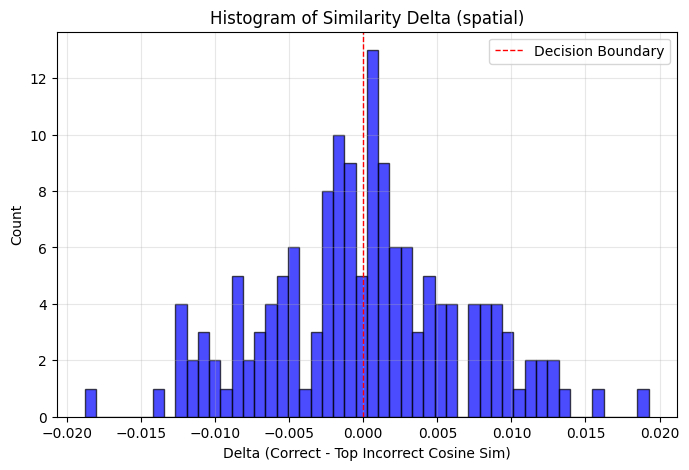

In [ ]:
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_text_head_experiments"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)
class SpatialHeadArgs:
    train_json = f"{DATA_ROOT}/spatial_1250/spatial_metadata.json"
    image_root = f"{DATA_ROOT}/spatial_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "spatial")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 1e-4
    epochs = 7

os.makedirs(SpatialHeadArgs.output_dir, exist_ok=True)

# 1. TRAIN
print("\n🚀 STARTING SPATIAL TEXT-HEAD TRAINING")
train_text_head(SpatialHeadArgs())

# 2. EVALUATE
print("\n📊 EVALUATING SPATIAL...")
evaluate_and_plot(
    "spatial",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset/spatial_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset",
    os.path.join(SpatialHeadArgs.output_dir, "text_head_best.pt")
)

LORA_TEXT

In [ ]:
from peft import LoraConfig, get_peft_model, PeftModel

# --- 1. LoRA Training Function (Fixed) ---
def train_lora_text(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load Base Model
    print(f"Loading {args.model_id}...")
    model = CLIPModel.from_pretrained(args.model_id)
    processor = CLIPProcessor.from_pretrained(args.model_id)

    # --- LoRA Configuration ---
    config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        modules_to_save=["text_projection"]
    )

    # Inject LoRA into the Text Model only
    model.text_model = get_peft_model(model.text_model, config)
    print("Model configured for LoRA (Text Encoder).")

    # --- FIX IS HERE: Call on text_model, not model ---
    model.text_model.print_trainable_parameters()

    model.to(device)

    # Data Loaders
    dataset = UnifiedClipDataset(args.train_json, args.image_root, processor, mode='train')
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, collate_fn=collate_fn)

    # Optimizer
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    # Training Loop
    best_val_acc = 0
    save_path = os.path.join(args.output_dir, "lora_text_best")

    for epoch in range(args.epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs}")
        for batch in pbar:
            optimizer.zero_grad()

            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            img_embeds = model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            B, K, SeqLen = input_ids.shape
            flat_input = input_ids.view(-1, SeqLen)
            flat_mask = attention_mask.view(-1, SeqLen)

            text_embeds = model.get_text_features(flat_input, flat_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
            logit_scale = model.logit_scale.exp()
            logits = logits * logit_scale

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += B
            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': train_correct/train_total})

        # Validation
        model.eval()
        val_correct = 0; val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                img_embeds = model.get_image_features(pixel_values)
                img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

                B, K, SeqLen = input_ids.shape
                flat_input = input_ids.view(-1, SeqLen)
                flat_mask = attention_mask.view(-1, SeqLen)

                text_embeds = model.get_text_features(flat_input, flat_mask)
                text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
                text_embeds = text_embeds.view(B, K, -1)

                logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += B

        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model.text_model.save_pretrained(save_path)
            print(f"Epoch {epoch+1}: Val Acc {val_acc:.4f} -> Saved Adapter to {save_path}")

# --- 2. LoRA Evaluation Function ---
def evaluate_lora(task_name, test_json_path, test_image_root, adapter_path):
    print(f"\n📊 EVALUATING LoRA ({task_name.upper()})...")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Load Base Model
    base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    # 2. Load and Apply LoRA Adapter
    # We apply it specifically to the text_model sub-component where we trained it
    print(f"Loading adapter from: {adapter_path}")
    base_model.text_model = PeftModel.from_pretrained(base_model.text_model, adapter_path)

    base_model.to(device)
    base_model.eval()

    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    test_dataset = UnifiedClipDataset(test_json_path, test_image_root, processor, mode='test')
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    # ... (Rest of logic is identical to standard eval) ...
    all_deltas = []
    all_is_correct = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            img_embeds = base_model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            B, K, SeqLen = input_ids.shape
            flat_input = input_ids.view(-1, SeqLen)
            flat_mask = attention_mask.view(-1, SeqLen)

            text_embeds = base_model.get_text_features(flat_input, flat_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            raw_scores = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)

            for i in range(B):
                correct_idx = labels[i].item()
                score_correct = raw_scores[i, correct_idx].item()
                mask = torch.ones(K, dtype=torch.bool)
                mask[correct_idx] = False
                score_top_incorrect = raw_scores[i][mask].max().item()

                delta = score_correct - score_top_incorrect
                pred_idx = raw_scores[i].argmax().item()

                all_deltas.append(delta)
                all_is_correct.append((pred_idx == correct_idx))

    all_deltas = np.array(all_deltas)
    accuracy = np.mean(all_is_correct) * 100
    mean_delta = np.mean(all_deltas)

    print("\n" + "="*40)
    print(f"LoRA RESULTS: {task_name.upper()}")
    print("="*40)
    print(f"Accuracy:             {accuracy:.2f}%")
    print(f"Mean Delta:           {mean_delta:.5f}")

    plt.figure(figsize=(8, 5))
    plt.hist(all_deltas, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"LoRA (Text) - {task_name}")
    plt.show()

🚀 STARTING NEGATION LoRA (TEXT) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Text Encoder).
trainable params: 196,608 || all params: 63,362,560 || trainable%: 0.3103


Epoch 1/7: 100%|██████████| 36/36 [00:33<00:00,  1.08it/s, loss=0.683, acc=0.593]


Epoch 1: Val Acc 0.7323 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/negation/lora_text_best


Epoch 2/7: 100%|██████████| 36/36 [00:32<00:00,  1.12it/s, loss=0.457, acc=0.793]


Epoch 2: Val Acc 0.7795 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/negation/lora_text_best


Epoch 7/7: 100%|██████████| 36/36 [00:32<00:00,  1.10it/s, loss=0.104, acc=0.964]



📊 EVALUATING LoRA (NEGATION)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/negation/lora_text_best


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]



LoRA RESULTS: NEGATION
Accuracy:             78.00%
Mean Delta:           0.00461


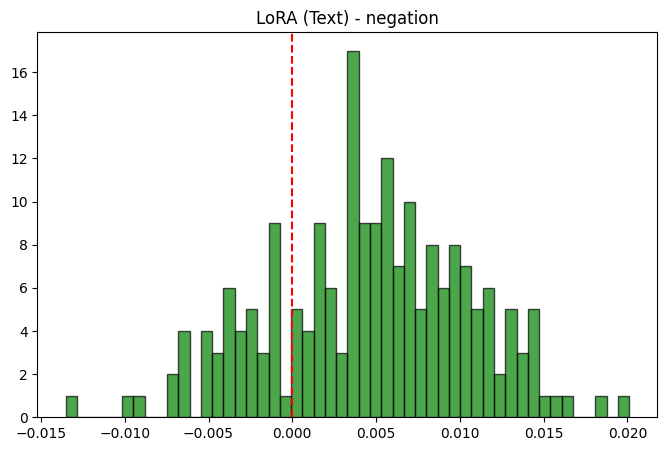

In [ ]:
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_lora_text_experiments"
class NegationLoraArgs:
    train_json = f"{DATA_ROOT}/negation_1250/negation_metadata.json"
    image_root = f"{DATA_ROOT}/negation_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "negation")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 5e-5  # Note: Lower LR for LoRA
    epochs = 7

os.makedirs(NegationLoraArgs.output_dir, exist_ok=True)

# Train
print("🚀 STARTING NEGATION LoRA (TEXT) TRAINING")
train_lora_text(NegationLoraArgs())

# Evaluate
evaluate_lora(
   "negation",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200/negation_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200",
    os.path.join(NegationLoraArgs.output_dir, "lora_text_best")
)

🚀 STARTING NUMERACY LoRA (TEXT) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Text Encoder).
trainable params: 196,608 || all params: 63,362,560 || trainable%: 0.3103


Epoch 1/6: 100%|██████████| 36/36 [00:37<00:00,  1.05s/it, loss=1.02, acc=0.422]


Epoch 1: Val Acc 0.4480 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/numeracy/lora_text_best


Epoch 2/6: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it, loss=0.973, acc=0.49]


Epoch 2: Val Acc 0.4560 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/numeracy/lora_text_best


Epoch 3/6: 100%|██████████| 36/36 [00:37<00:00,  1.04s/it, loss=0.959, acc=0.444]


Epoch 3: Val Acc 0.4880 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/numeracy/lora_text_best


Epoch 6/6: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it, loss=0.945, acc=0.493]



📊 EVALUATING LoRA (NUMERACY)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/numeracy/lora_text_best


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]



LoRA RESULTS: NUMERACY
Accuracy:             28.00%
Mean Delta:           -0.00130


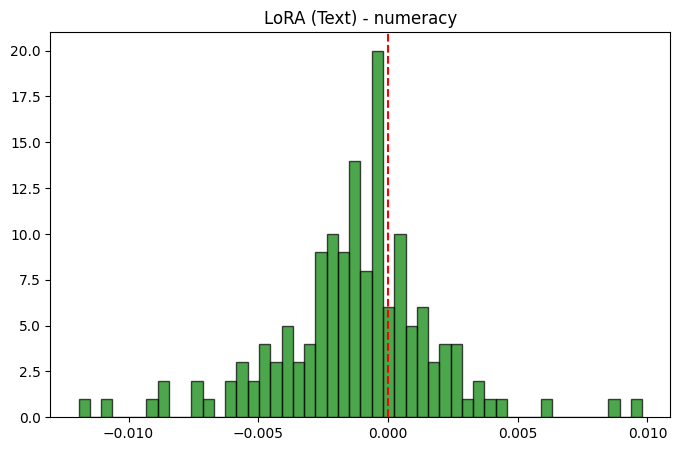

In [ ]:
class NumeracyLoraArgs:
    train_json = f"{DATA_ROOT}/numeracy_1250/numeracy_metadata_fixed.json"
    image_root = f"{DATA_ROOT}/numeracy_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "numeracy")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 5e-5
    epochs = 6

os.makedirs(NumeracyLoraArgs.output_dir, exist_ok=True)

print("🚀 STARTING NUMERACY LoRA (TEXT) TRAINING")
train_lora_text(NumeracyLoraArgs())

evaluate_lora(
    "numeracy",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150/numeracy_metadata_fixed.json",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150",
    os.path.join(NumeracyLoraArgs.output_dir, "lora_text_best")
)

🚀 STARTING ATTRIBUTE LoRA (TEXT) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Text Encoder).
trainable params: 196,608 || all params: 63,362,560 || trainable%: 0.3103


Epoch 1/6: 100%|██████████| 36/36 [00:45<00:00,  1.25s/it, loss=0.762, acc=0.46]


Epoch 1: Val Acc 0.4320 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/attribute/lora_text_best


Epoch 6/6: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s, loss=0.699, acc=0.495]



📊 EVALUATING LoRA (ATTRIBUTE)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/attribute/lora_text_best


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


LoRA RESULTS: ATTRIBUTE
Accuracy:             54.00%
Mean Delta:           0.00032


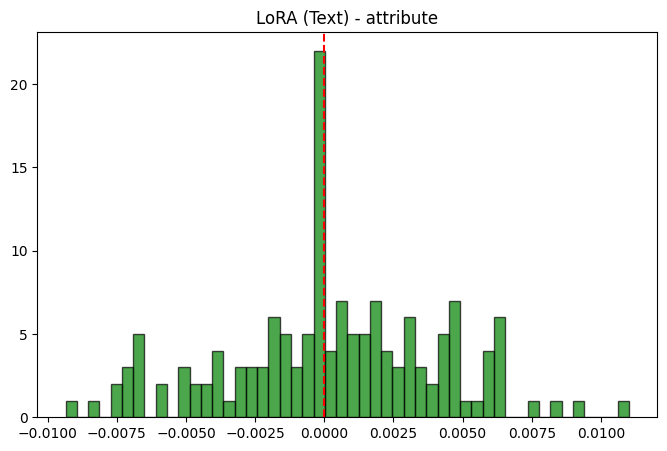

In [ ]:
class AttributeLoraArgs:
    train_json = f"{DATA_ROOT}/attribute_1250/attributes_metadata.json"
    image_root = f"{DATA_ROOT}/attribute_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "attribute")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 5e-5
    epochs = 6

os.makedirs(AttributeLoraArgs.output_dir, exist_ok=True)

print("🚀 STARTING ATTRIBUTE LoRA (TEXT) TRAINING")
train_lora_text(AttributeLoraArgs())

evaluate_lora(
    "attribute",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset/attributes_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset",
    os.path.join(AttributeLoraArgs.output_dir, "lora_text_best")
)

🚀 STARTING SPATIAL LoRA (TEXT) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Text Encoder).
trainable params: 196,608 || all params: 63,362,560 || trainable%: 0.3103


Epoch 1/6: 100%|██████████| 36/36 [00:32<00:00,  1.12it/s, loss=0.755, acc=0.488]


Epoch 1: Val Acc 0.4080 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/spatial/lora_text_best


Epoch 2/6: 100%|██████████| 36/36 [00:32<00:00,  1.12it/s, loss=0.708, acc=0.473]


Epoch 2: Val Acc 0.4560 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/spatial/lora_text_best


Epoch 6/6: 100%|██████████| 36/36 [00:33<00:00,  1.09it/s, loss=0.698, acc=0.464]



📊 EVALUATING LoRA (SPATIAL)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_text_experiments/spatial/lora_text_best


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


LoRA RESULTS: SPATIAL
Accuracy:             49.33%
Mean Delta:           0.00001


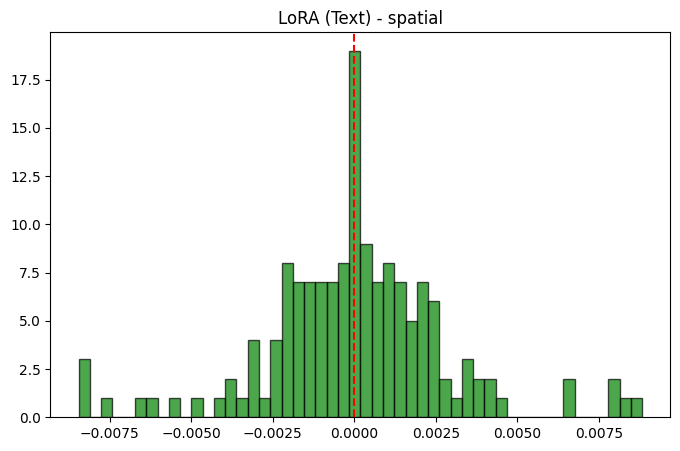

In [ ]:
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_lora_text_experiments"
class SpatialLoraArgs:
    train_json = f"{DATA_ROOT}/spatial_1250/spatial_metadata.json"
    image_root = f"{DATA_ROOT}/spatial_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "spatial")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 5e-5
    epochs = 6

os.makedirs(SpatialLoraArgs.output_dir, exist_ok=True)

print("🚀 STARTING SPATIAL LoRA (TEXT) TRAINING")
train_lora_text(SpatialLoraArgs())

evaluate_lora(
    "spatial",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset/spatial_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset",
    os.path.join(SpatialLoraArgs.output_dir, "lora_text_best")
)

LORA (Both image and text encoder)

In [ ]:
# --- 1. LoRA Both Training Function ---
def train_lora_both(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    print(f"Loading {args.model_id}...")
    model = CLIPModel.from_pretrained(args.model_id)
    processor = CLIPProcessor.from_pretrained(args.model_id)

    # --- LoRA Config for BOTH Encoders ---
    config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"], # Will find these in BOTH encoders
        lora_dropout=0.05,
        bias="none",
        # CRITICAL: We unfreeze BOTH projection layers to allow full realignment
        modules_to_save=["visual_projection", "text_projection"]
    )

    # Apply to the ROOT model (not just text_model)
    model = get_peft_model(model, config)
    print("Model configured for LoRA (Vision + Text).")
    model.print_trainable_parameters()

    model.to(device)

    # Data Loaders (Same as before)
    dataset = UnifiedClipDataset(args.train_json, args.image_root, processor, mode='train')
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, collate_fn=collate_fn)

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    save_path = os.path.join(args.output_dir, "lora_both_best")

    for epoch in range(args.epochs):
        model.train()
        train_loss = 0; train_correct = 0; train_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs}")
        for batch in pbar:
            optimizer.zero_grad()

            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            img_embeds = model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            B, K, SeqLen = input_ids.shape
            flat_input = input_ids.view(-1, SeqLen)
            flat_mask = attention_mask.view(-1, SeqLen)

            text_embeds = model.get_text_features(flat_input, flat_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
            logit_scale = model.logit_scale.exp()
            logits = logits * logit_scale

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += B
            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': train_correct/train_total})

        # Validation
        model.eval()
        val_correct = 0; val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                img_embeds = model.get_image_features(pixel_values)
                img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

                B, K, SeqLen = input_ids.shape
                flat_input = input_ids.view(-1, SeqLen)
                flat_mask = attention_mask.view(-1, SeqLen)

                text_embeds = model.get_text_features(flat_input, flat_mask)
                text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
                text_embeds = text_embeds.view(B, K, -1)

                logits = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += B

        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save the ROOT model adapter
            model.save_pretrained(save_path)
            print(f"Epoch {epoch+1}: Val Acc {val_acc:.4f} -> Saved Adapter to {save_path}")

# --- 2. LoRA Both Evaluation Function ---
def evaluate_lora_both(task_name, test_json_path, test_image_root, adapter_path):
    print(f"\n📊 EVALUATING LoRA BOTH ({task_name.upper()})...")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Load Base Model
    base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    # 2. Load Adapter onto ROOT model
    print(f"Loading adapter from: {adapter_path}")
    # Note: We apply to base_model directly, not base_model.text_model
    model = PeftModel.from_pretrained(base_model, adapter_path)

    model.to(device)
    model.eval()

    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    test_dataset = UnifiedClipDataset(test_json_path, test_image_root, processor, mode='test')
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    all_deltas = []
    all_is_correct = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            img_embeds = model.get_image_features(pixel_values)
            img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)

            B, K, SeqLen = input_ids.shape
            flat_input = input_ids.view(-1, SeqLen)
            flat_mask = attention_mask.view(-1, SeqLen)

            text_embeds = model.get_text_features(flat_input, flat_mask)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds.view(B, K, -1)

            raw_scores = torch.einsum('bd,bkd->bk', img_embeds, text_embeds)

            for i in range(B):
                correct_idx = labels[i].item()
                score_correct = raw_scores[i, correct_idx].item()
                mask = torch.ones(K, dtype=torch.bool)
                mask[correct_idx] = False
                score_top_incorrect = raw_scores[i][mask].max().item()

                delta = score_correct - score_top_incorrect
                pred_idx = raw_scores[i].argmax().item()

                all_deltas.append(delta)
                all_is_correct.append((pred_idx == correct_idx))

    all_deltas = np.array(all_deltas)
    accuracy = np.mean(all_is_correct) * 100
    mean_delta = np.mean(all_deltas)

    print("\n" + "="*40)
    print(f"LoRA BOTH RESULTS: {task_name.upper()}")
    print("="*40)
    print(f"Accuracy:             {accuracy:.2f}%")
    print(f"Mean Delta:           {mean_delta:.5f}")

    plt.figure(figsize=(8, 5))
    plt.hist(all_deltas, bins=50, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"LoRA (Both) - {task_name}")
    plt.show()

🚀 STARTING NEGATION LoRA (BOTH) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Vision + Text).
trainable params: 1,146,880 || all params: 152,424,193 || trainable%: 0.7524


Epoch 1/6: 100%|██████████| 36/36 [00:29<00:00,  1.24it/s, loss=0.512, acc=0.787]


Epoch 1: Val Acc 0.8346 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/negation/lora_both_best


Epoch 2/6: 100%|██████████| 36/36 [00:28<00:00,  1.24it/s, loss=0.27, acc=0.913]


Epoch 2: Val Acc 0.8583 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/negation/lora_both_best


Epoch 3/6: 100%|██████████| 36/36 [00:29<00:00,  1.21it/s, loss=0.138, acc=0.964]


Epoch 3: Val Acc 0.8740 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/negation/lora_both_best


Epoch 5/6: 100%|██████████| 36/36 [00:29<00:00,  1.21it/s, loss=0.0346, acc=0.997]


Epoch 5: Val Acc 0.8898 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/negation/lora_both_best


Epoch 6/6: 100%|██████████| 36/36 [00:29<00:00,  1.21it/s, loss=0.0157, acc=0.999]



📊 EVALUATING LoRA BOTH (NEGATION)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/negation/lora_both_best


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]



LoRA BOTH RESULTS: NEGATION
Accuracy:             91.50%
Mean Delta:           0.05161


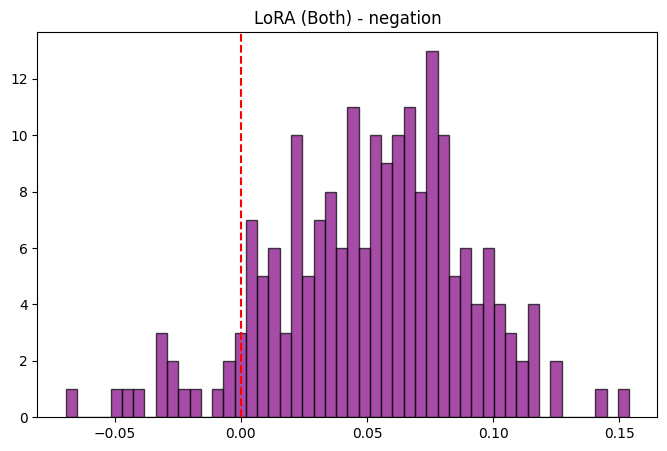

In [ ]:
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_lora_both_experiments"
class NegationLoraBothArgs:
    train_json = f"{DATA_ROOT}/negation_1250/negation_metadata.json"
    image_root = f"{DATA_ROOT}/negation_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "negation")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 2e-5
    epochs = 6

os.makedirs(NegationLoraBothArgs.output_dir, exist_ok=True)

print("🚀 STARTING NEGATION LoRA (BOTH) TRAINING")
train_lora_both(NegationLoraBothArgs())

evaluate_lora_both(
   "negation",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200/negation_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/negation_200",
    os.path.join(NegationLoraBothArgs.output_dir, "lora_both_best")
)

🚀 STARTING NUMERACY LoRA (BOTH) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Vision + Text).
trainable params: 1,146,880 || all params: 152,424,193 || trainable%: 0.7524


Epoch 1/7: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s, loss=1, acc=0.383]


Epoch 1: Val Acc 0.4560 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/numeracy/lora_both_best


Epoch 2/7: 100%|██████████| 36/36 [00:35<00:00,  1.01it/s, loss=0.889, acc=0.556]


Epoch 2: Val Acc 0.4800 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/numeracy/lora_both_best


Epoch 3/7: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s, loss=0.817, acc=0.636]


Epoch 3: Val Acc 0.4960 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/numeracy/lora_both_best


Epoch 5/7: 100%|██████████| 36/36 [00:34<00:00,  1.03it/s, loss=0.63, acc=0.741]


Epoch 5: Val Acc 0.5280 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/numeracy/lora_both_best


Epoch 7/7: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s, loss=0.454, acc=0.836]



📊 EVALUATING LoRA BOTH (NUMERACY)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/numeracy/lora_both_best


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


LoRA BOTH RESULTS: NUMERACY
Accuracy:             58.67%
Mean Delta:           0.00517


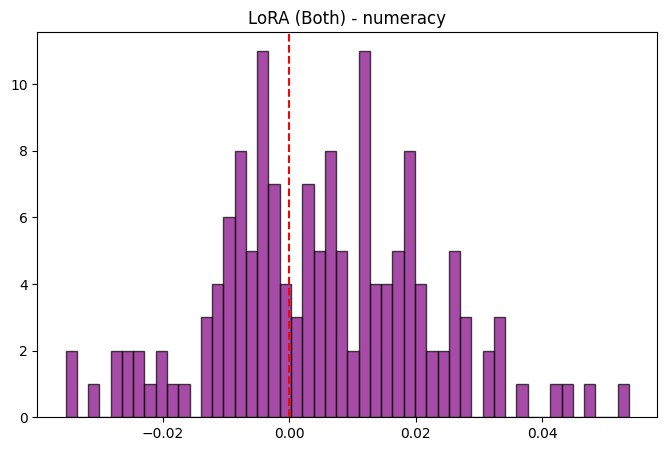

In [ ]:
class NumeracyLoraBothArgs:
    train_json = f"{DATA_ROOT}/numeracy_1250/numeracy_metadata_fixed.json"
    image_root = f"{DATA_ROOT}/numeracy_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "numeracy")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 2e-5
    epochs = 7

os.makedirs(NumeracyLoraBothArgs.output_dir, exist_ok=True)

print("🚀 STARTING NUMERACY LoRA (BOTH) TRAINING")
train_lora_both(NumeracyLoraBothArgs())

evaluate_lora_both(
    "numeracy",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150/numeracy_metadata_fixed.json",
   "/content/gdrive/MyDrive/team_biased/testBed/numeracy_150",
    os.path.join(NumeracyLoraBothArgs.output_dir, "lora_both_best")
)

🚀 STARTING ATTRIBUTE LoRA (BOTH) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Vision + Text).
trainable params: 1,146,880 || all params: 152,424,193 || trainable%: 0.7524


Epoch 1/10: 100%|██████████| 36/36 [00:32<00:00,  1.11it/s, loss=0.708, acc=0.51]


Epoch 1: Val Acc 0.4480 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 3/10: 100%|██████████| 36/36 [00:32<00:00,  1.10it/s, loss=0.594, acc=0.673]


Epoch 3: Val Acc 0.4560 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 4/10: 100%|██████████| 36/36 [00:32<00:00,  1.11it/s, loss=0.511, acc=0.737]


Epoch 4: Val Acc 0.6080 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 5/10: 100%|██████████| 36/36 [00:32<00:00,  1.12it/s, loss=0.399, acc=0.82]


Epoch 5: Val Acc 0.7040 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 6/10: 100%|██████████| 36/36 [00:31<00:00,  1.13it/s, loss=0.299, acc=0.852]


Epoch 6: Val Acc 0.7520 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 8/10: 100%|██████████| 36/36 [00:32<00:00,  1.11it/s, loss=0.198, acc=0.891]


Epoch 8: Val Acc 0.7920 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 9/10: 100%|██████████| 36/36 [00:32<00:00,  1.11it/s, loss=0.174, acc=0.913]


Epoch 9: Val Acc 0.8000 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


Epoch 10/10: 100%|██████████| 36/36 [00:32<00:00,  1.12it/s, loss=0.149, acc=0.92]



📊 EVALUATING LoRA BOTH (ATTRIBUTE)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/attribute/lora_both_best


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


LoRA BOTH RESULTS: ATTRIBUTE
Accuracy:             88.00%
Mean Delta:           0.06645


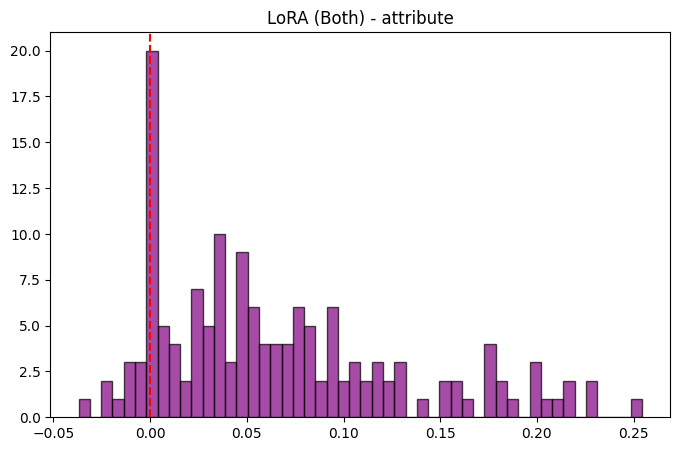

In [ ]:
class AttributeLoraBothArgs:
    train_json = f"{DATA_ROOT}/attribute_1250/attributes_metadata.json"
    image_root = f"{DATA_ROOT}/attribute_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "attribute")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 2e-5
    epochs = 10

os.makedirs(AttributeLoraBothArgs.output_dir, exist_ok=True)

print("🚀 STARTING ATTRIBUTE LoRA (BOTH) TRAINING")
train_lora_both(AttributeLoraBothArgs())

evaluate_lora_both(
    "attribute",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset/attributes_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/attr_binding_dataset",
    os.path.join(AttributeLoraBothArgs.output_dir, "lora_both_best")
)

🚀 STARTING SPATIAL LoRA (BOTH) TRAINING
Using device: cuda
Loading openai/clip-vit-base-patch32...
Model configured for LoRA (Vision + Text).
trainable params: 1,146,880 || all params: 152,424,193 || trainable%: 0.7524


Epoch 1/10: 100%|██████████| 36/36 [00:29<00:00,  1.21it/s, loss=0.731, acc=0.489]


Epoch 1: Val Acc 0.5120 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/spatial/lora_both_best


Epoch 6/10: 100%|██████████| 36/36 [00:29<00:00,  1.22it/s, loss=0.626, acc=0.642]


Epoch 6: Val Acc 0.6000 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/spatial/lora_both_best


Epoch 7/10: 100%|██████████| 36/36 [00:29<00:00,  1.21it/s, loss=0.424, acc=0.852]


Epoch 7: Val Acc 0.9360 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/spatial/lora_both_best


Epoch 8/10: 100%|██████████| 36/36 [00:29<00:00,  1.23it/s, loss=0.0448, acc=0.997]


Epoch 8: Val Acc 1.0000 -> Saved Adapter to /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/spatial/lora_both_best


Epoch 10/10: 100%|██████████| 36/36 [00:29<00:00,  1.23it/s, loss=0.000554, acc=1]



📊 EVALUATING LoRA BOTH (SPATIAL)...
Loading adapter from: /content/gdrive/MyDrive/team_biased/clip_lora_both_experiments/spatial/lora_both_best


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


LoRA BOTH RESULTS: SPATIAL
Accuracy:             100.00%
Mean Delta:           0.07470


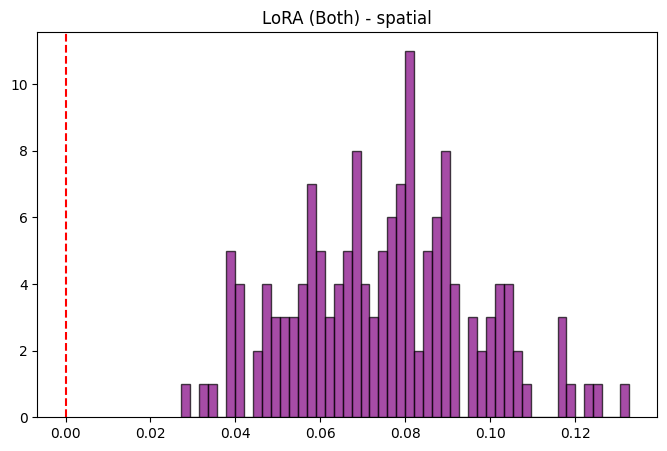

In [ ]:
DRIVE_OUTPUT = "/content/gdrive/MyDrive/team_biased/clip_lora_both_experiments"
class SpatialLoraBothArgs:
    train_json = f"{DATA_ROOT}/spatial_1250/spatial_metadata.json"
    image_root = f"{DATA_ROOT}/spatial_1250"
    output_dir = os.path.join(DRIVE_OUTPUT, "spatial")
    model_id = "openai/clip-vit-base-patch32"
    batch_size = 32
    lr = 2e-5
    epochs = 10

os.makedirs(SpatialLoraBothArgs.output_dir, exist_ok=True)

print("🚀 STARTING SPATIAL LoRA (BOTH) TRAINING")
train_lora_both(SpatialLoraBothArgs())

evaluate_lora_both(
   "spatial",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset/spatial_metadata.json",
   "/content/gdrive/MyDrive/team_biased/testBed/spatial_mcq_dataset",
    os.path.join(SpatialLoraBothArgs.output_dir, "lora_both_best")
)